#Imports


In [3]:
# Main Libraries
import tensorflow as tf
import keras
# Load Dataset Functions and Data Augmentation Functions
from keras.utils import image_dataset_from_directory
from tensorflow import image as augment
# Plotting Image
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import os
# Layers, Metrics and Optimizers Functions
from keras.layers import Dense , Dropout , GlobalAveragePooling2D , Input
from keras.metrics import F1Score , Accuracy
from keras.optimizers import Adam
# Models and Applications Functions
from keras.models import Model
from keras.applications import MobileNetV3Large
from keras.applications import ResNet50
from keras.applications import InceptionV3
from keras.applications import EfficientNetV2B3
# Every Application Preprocessing Functions
from keras.applications.mobilenet_v3 import preprocess_input as mobilepre
from keras.applications.resnet50 import preprocess_input as resnetpre
from keras.applications.inception_v3 import preprocess_input as inceptionpre
from keras.applications.efficientnet_v2 import preprocess_input as efficientnetpre


#Dataset


## Downloading Dataset

In [4]:
!gdown 1O4YR4UBatOLnaP4gMHbmFw7UJvhhxFwq
!gdown 1-7aMdKW4KcCKLwoUKC3XxdIwfIKkzwx6

Downloading...
From: https://drive.google.com/uc?id=1O4YR4UBatOLnaP4gMHbmFw7UJvhhxFwq
To: /content/train_data.zip
100% 173M/173M [00:00<00:00, 232MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-7aMdKW4KcCKLwoUKC3XxdIwfIKkzwx6
To: /content/test_data.zip
100% 73.0M/73.0M [00:00<00:00, 279MB/s]


## Unzipping dataset


In [5]:
!unzip 'test_data.zip'
!unzip 'train_data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train_data/10/fac187c69fc74a48d28e626bd17fe5b0d36db1e6_1618836534.jpg  
  inflating: train_data/10/9a9f9ff4d3dcfc88e6b9209178d4ee791142fdaa_1618725283.jpg  
  inflating: train_data/10/958281d27ab722113c92180afe17db62bfb6a5d0_1623743398.jpg  
  inflating: train_data/10/8a94fada61bcb6dda8983dc36ddf2ec5d32cbf9f_1629199040.jpg  
  inflating: train_data/10/d72c1b799a927514b1fd81d9ee93208734be4d61_1613975034.jpg  
  inflating: train_data/10/6550a6492a93a9542b7757c898369f7996bb62b7_1613978514.jpg  
  inflating: train_data/10/3465c07dc8a3521f0303cec03ebbc4ac2d738317_1630174913.jpg  
  inflating: train_data/10/74a657eb2f8bc1a9bcd42fee32d04b1a400fcddf_1627746721.jpg  
  inflating: train_data/10/387c4a5ef5d37c263ebe457a2aab08890da843ca_1620800188.jpg  
  inflating: train_data/10/01330eb299562e0e10bdc560e7ed12754f49703b_1621081068.jpg  
  inflating: train_data/10/1ea75672aea3496a099cc3c8d8e2c01306456a52_1619644153.jpg  
  inflating: t

## Loading Dataset

### Train Dataset

In [6]:
root = 'train_data'

In [7]:
train_dataset = image_dataset_from_directory(root , validation_split = 0.2 , seed = 42 , image_size = (456, 456) , subset = 'training', batch_size = 32 )
type(train_dataset)

Found 9990 files belonging to 10 classes.
Using 7992 files for training.


tensorflow.python.data.ops.prefetch_op._PrefetchDataset

### Validation Dataset

In [8]:
validation_dataset = image_dataset_from_directory(root , validation_split = 0.2 , seed = 42 , image_size = (456 , 456) , subset = 'validation' , batch_size =32)
type(validation_dataset)

Found 9990 files belonging to 10 classes.
Using 1998 files for validation.


tensorflow.python.data.ops.prefetch_op._PrefetchDataset

## Plotting Images
Using matplotlib, os and pathlib to plot 5 random images from each class in ten rows and five columns which is totally 50 images.

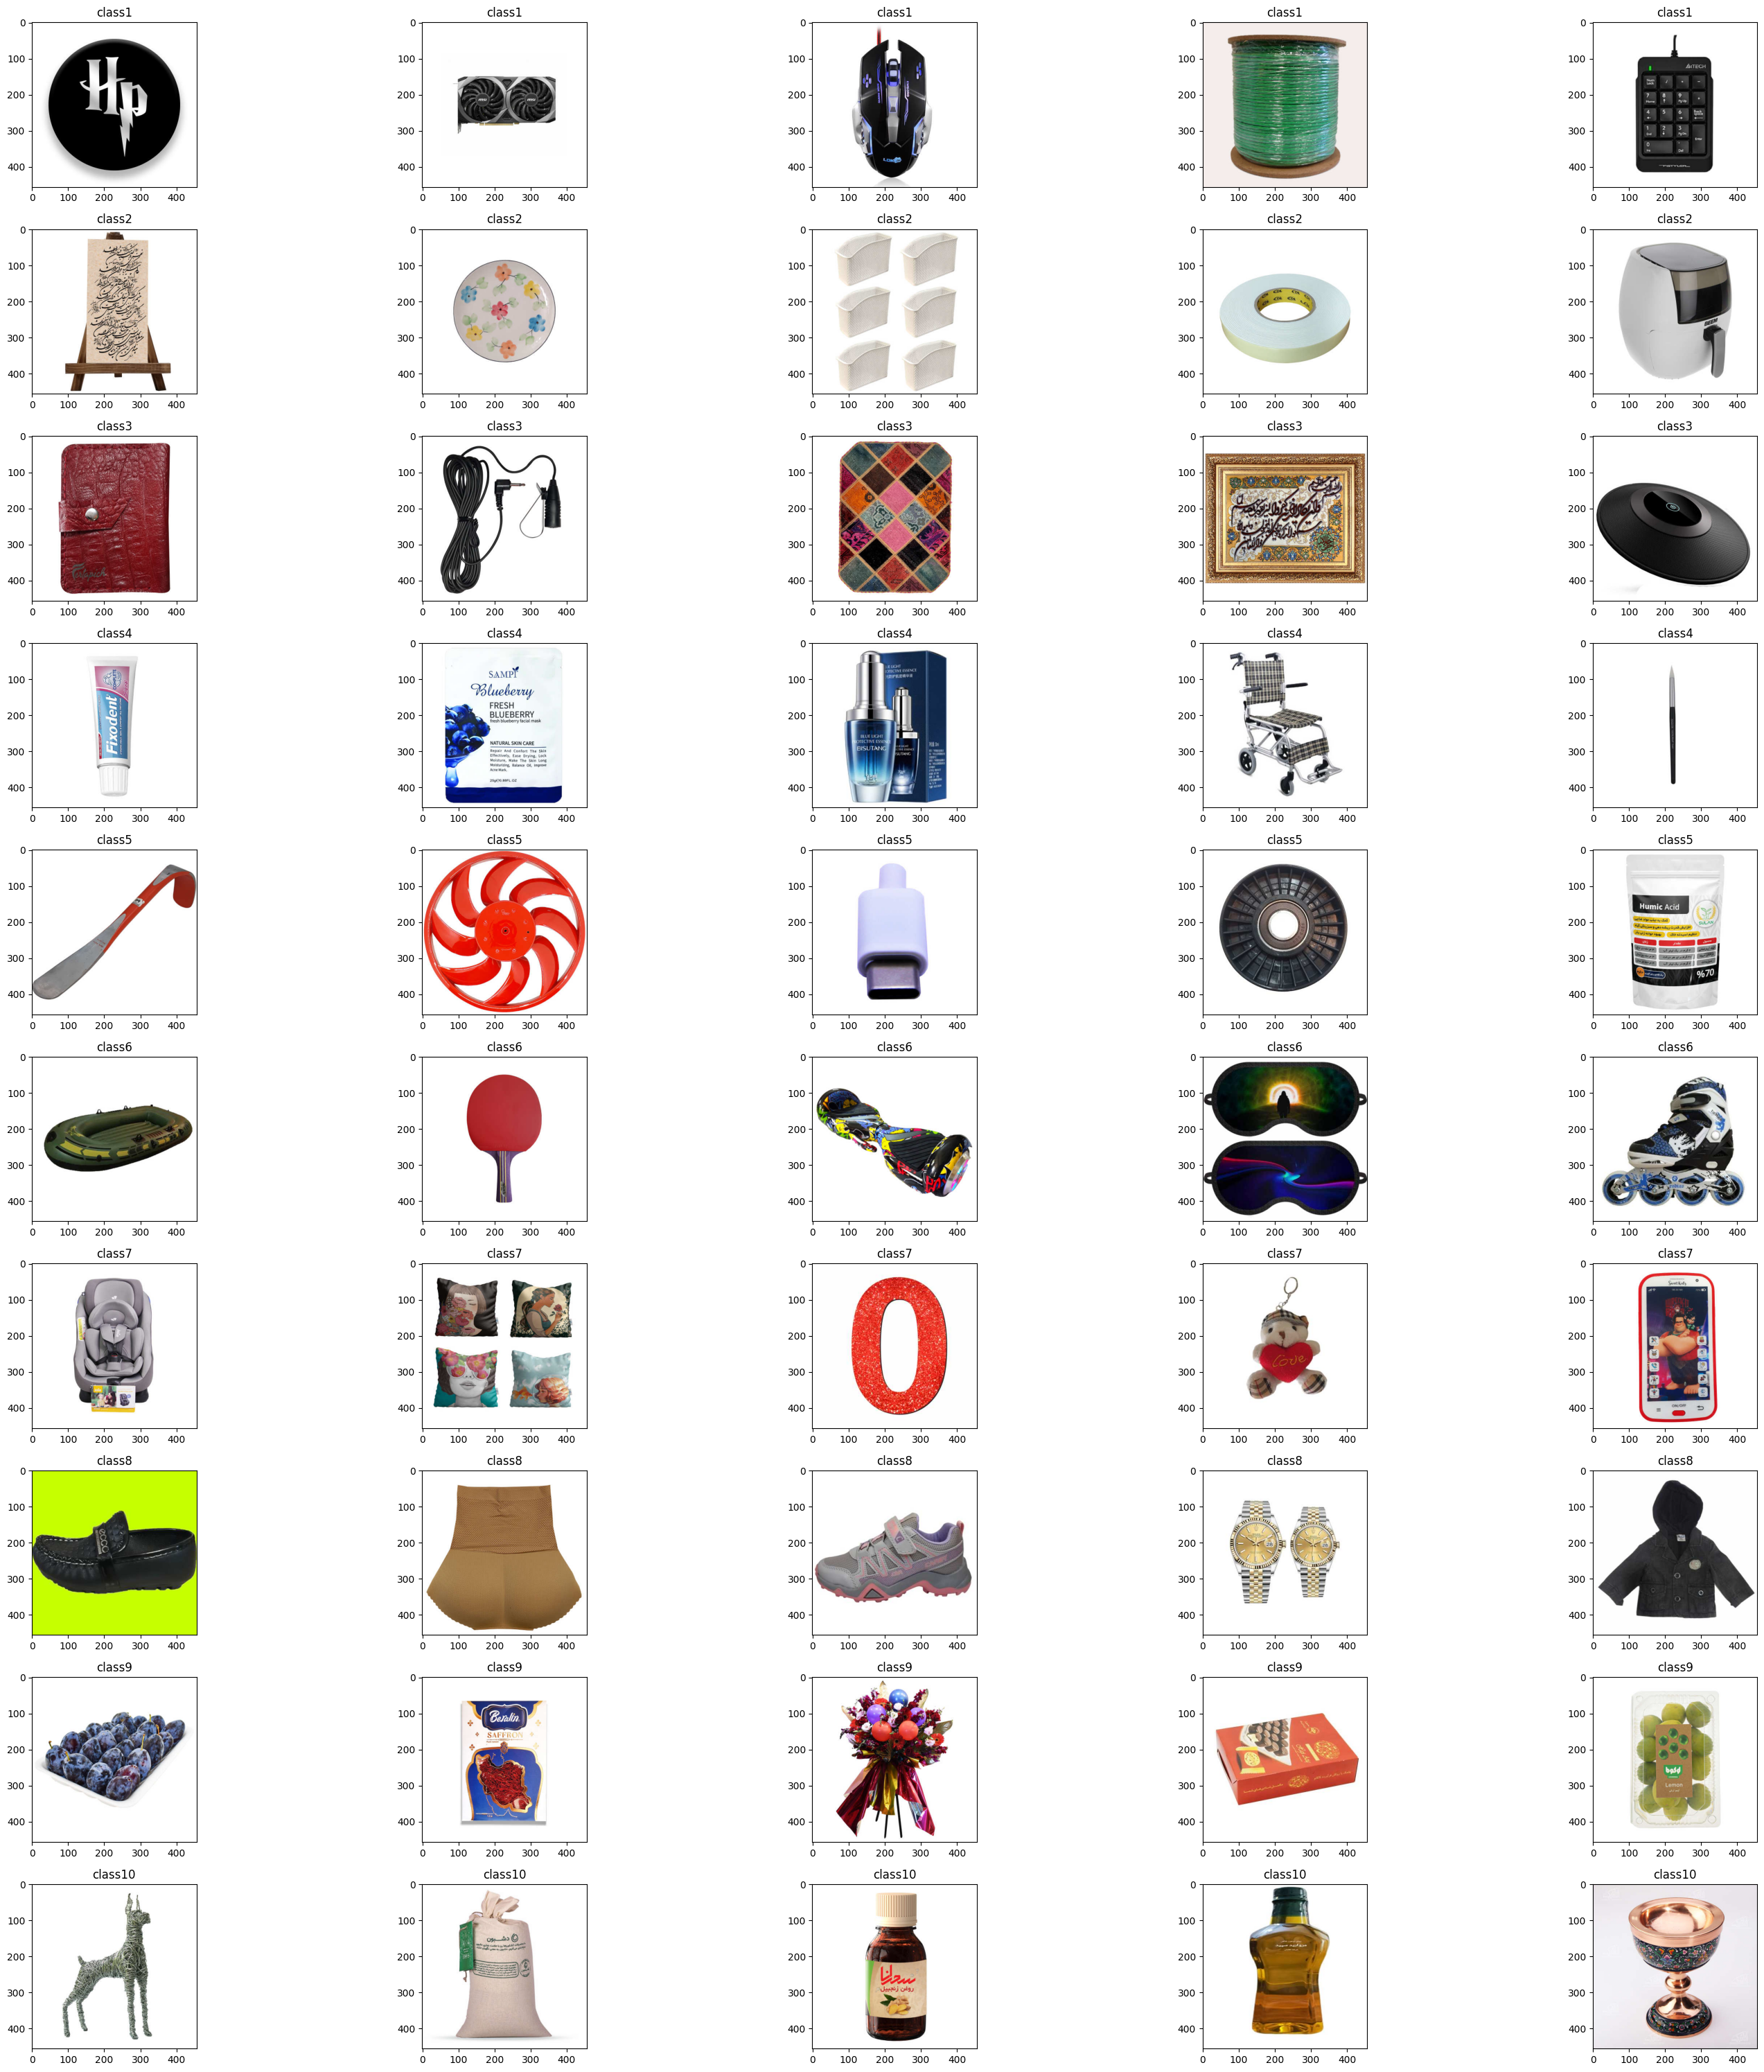

In [9]:
root_path = pathlib.Path('train_data')
fig , ax = plt.subplots(nrows = 10 , ncols = 5 , figsize = (30 , 30))
for i in range(1 , 11):
  current_class_dir = root_path / f'{i}'
  files = os.listdir(current_class_dir)
  for j in range(5):
    random_images = os.path.join(current_class_dir , random.choice(files))
    img = mpimg.imread(random_images)
    ax[i-1][j].imshow(img)
    ax[i-1][j].set_title(f'class{i}')

plt.tight_layout()

#Data Augmentation
Here we augment data and changing labels to one hot.

In [10]:
def DataAugmentation(image , label):
  image = augment.random_flip_left_right(image)
  iamge = augment.random_flip_up_down(image)
  image = augment.rot90(image , k = tf.random.uniform(shape = [] , minval = 0 , maxval = 4 , dtype = tf.int32))
  image = augment.random_brightness(image , max_delta = 0.2)
  image = augment.random_contrast(image , lower = 0.8 , upper = 1.2)
  image = augment.random_saturation(image , lower = 0.8 , upper = 1.2)
  image = augment.random_hue(image , max_delta = 0.2)

  return image , label

train_dataset = train_dataset.map(DataAugmentation , num_parallel_calls = tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(lambda x , y: (x , tf.one_hot(y , 10)))
validation_dataset = validation_dataset.map(lambda x ,y: (x , tf.one_hot(y , 10)))

#Training Models


In [11]:
num_classes = 10

##MobileNetV3Large



### Preprocessing , Setting Layers and Compiling Custom Model
I add GlobalPoolingAverage2D(), Dropout with 0.4 rate , Dense with 1024 units , Dropout with 0.2 rate and output by Dense layer with 10 units.

12683000/12683000 [==============================] - 0s 0us/step


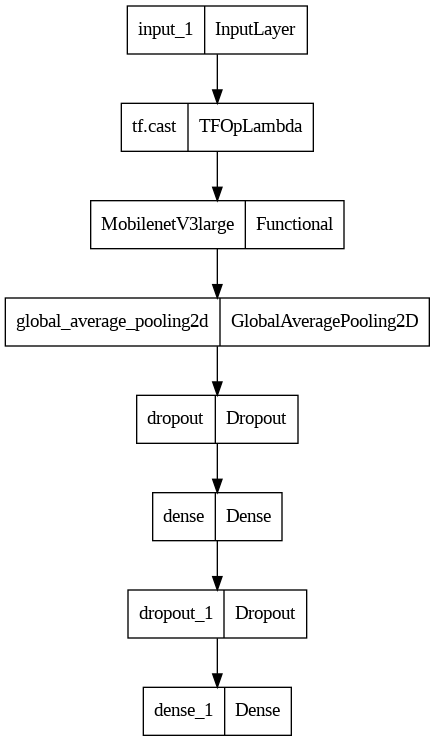

In [12]:
input_layer = Input([456 , 456 ,3])
x = tf.cast(input_layer , dtype = tf.float32)
x = mobilepre(x)

mobilenet_model = MobileNetV3Large(weights = 'imagenet' ,include_top = False)(x)

output_layer = GlobalAveragePooling2D()(mobilenet_model)
output_layer = Dropout(0.4)(output_layer)
output_layer = Dense(1024,  activation = 'relu')(output_layer)
output_layer = Dropout(0.2)(output_layer)
output_layer = Dense(num_classes , activation = 'softmax')(output_layer)

mobilenet_custom_model = Model(inputs = input_layer , outputs = output_layer)

mobilenet_custom_model.compile(optimizer = Adam(0.0001) , loss= 'categorical_crossentropy' , metrics = [F1Score(average = 'micro')])
keras.utils.plot_model(mobilenet_custom_model)

### Fitting Model

In [1]:
mobilenet_custom_model.fit(train_dataset , validation_data = validation_dataset , epochs =100)

NameError: ignored

## ResNet50

### Preprocessing , Setting Layers and Compiling Custom Model

94765736/94765736 [==============================] - 0s 0us/step


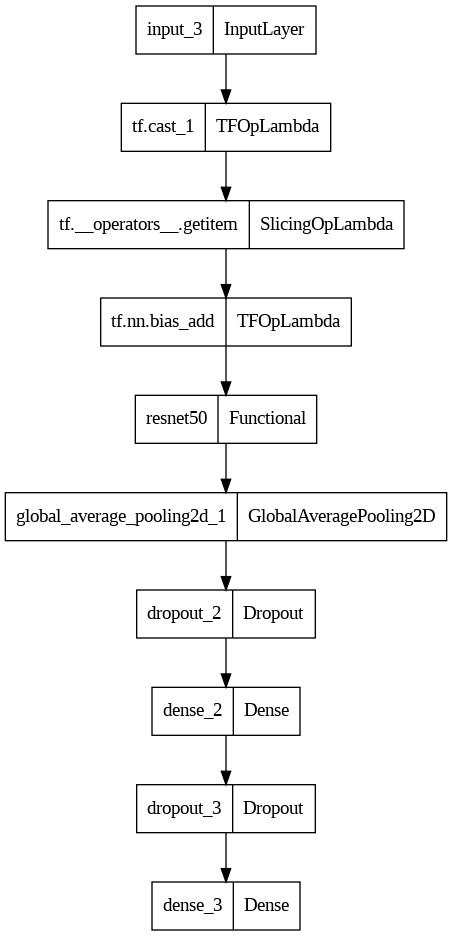

In [13]:
input_layer = Input([456 , 456 , 3])
x = tf.cast(input_layer , dtype = tf.float32)
x = resnetpre(x)

resnet_model = ResNet50(weights = 'imagenet' , include_top = False)(x)

output_layer = GlobalAveragePooling2D()(resnet_model)
output_layer = Dropout(0.4)(output_layer)
output_layer = Dense(1024, activation = 'relu')(output_layer)
output_layer = Dropout(0.2)(output_layer)
output_layer = Dense(num_classes , activation = 'softmax')(output_layer)

resnet_custom_model = Model(inputs = input_layer , outputs = output_layer)
resnet_custom_model.compile(optimizer = Adam(0.0001) , loss = 'categorical_crossentropy' , metrics = [F1Score(average = 'micro')])
keras.utils.plot_model(resnet_custom_model)

### Fitting Model

In [16]:
resnet_custom_model.fit(train_dataset , validation_data = validation_dataset , epochs =100)

Epoch 1/100
250/250 [==============================] - 420s 1s/step - loss: 1.8149 - f1_score: 0.3719 - val_loss: 1.9572 - val_f1_score: 0.3834
Epoch 2/100
250/250 [==============================] - 381s 2s/step - loss: 1.4817 - f1_score: 0.4961 - val_loss: 1.6233 - val_f1_score: 0.4730
Epoch 3/100
250/250 [==============================] - 379s 2s/step - loss: 1.3394 - f1_score: 0.5443 - val_loss: 1.4759 - val_f1_score: 0.5095
Epoch 4/100
250/250 [==============================] - 379s 2s/step - loss: 1.1891 - f1_score: 0.5928 - val_loss: 1.5477 - val_f1_score: 0.5085
Epoch 5/100
250/250 [==============================] - 381s 2s/step - loss: 1.1015 - f1_score: 0.6231 - val_loss: 1.5280 - val_f1_score: 0.5445
Epoch 6/100
250/250 [==============================] - 364s 1s/step - loss: 0.9885 - f1_score: 0.6668 - val_loss: 1.7156 - val_f1_score: 0.4925
Epoch 7/100
250/250 [==============================] - 364s 1s/step - loss: 0.9002 - f1_score: 0.6968 - val_loss: 1.7949 - val_f1_score:

KeyboardInterrupt: ignored

## InceptionV3

#### Preprocessing , Setting Layers and Compiling Custom Model
I add GlobalPoolingAverage2D(), Dropout with 0.4 rate , Dense with 1024 units , Dropout with 0.2 rate and output by Dense layer with 10 units.

87910968/87910968 [==============================] - 0s 0us/step


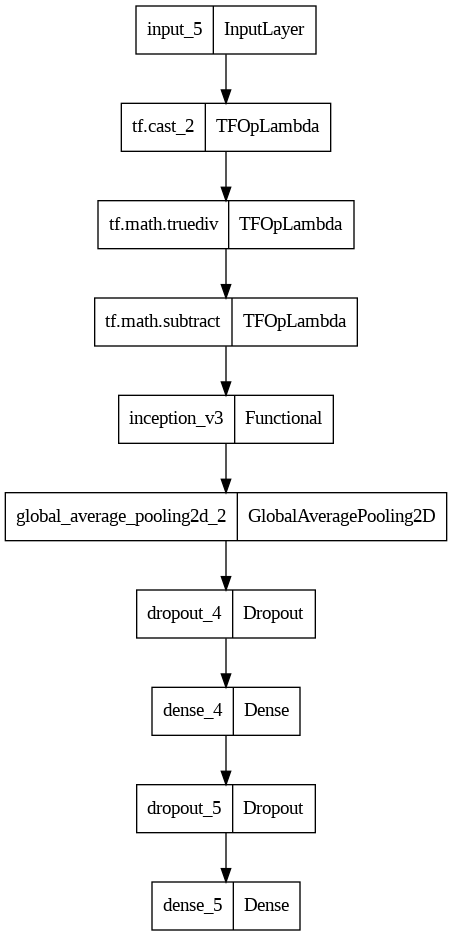

In [14]:
input_layer = Input([456 , 456 ,3])
x = tf.cast(input_layer , dtype = tf.float32)
x = inceptionpre(x)

inception_model = InceptionV3(weights = 'imagenet' , include_top = False)(x)

output_layer = GlobalAveragePooling2D()(inception_model)
output_layer = Dropout(0.4)(output_layer)
output_layer = Dense(1024 , activation = 'relu')(output_layer)
output_layer = Dropout(0.2)(output_layer)
output_layer = Dropout(512 , activation = 'relu')(output_layer) # Added Dense
output_layer = Dense(num_classes , activation = 'softmax')(output_layer)

inception_custom_model = Model(inputs= input_layer , outputs = output_layer)

inception_custom_model.compile(optimizer = Adam(0.0001) , loss = 'categorical_crossentropy' , metrics = [F1Score(average = 'micro')])

keras.utils.plot_model(inception_custom_model)

### Fitting Model

In [ ]:
inception_custom_model.fit(train_dataset , validation_data = validation_dataset , epochs = 100)

##EfficientNetV2B3

### Preprocessing , Setting Layers and Compiling Model
I add GlobalPoolingAverage2D(), Dropout with 0.4 rate , Dense with 1024 units , Dropout with 0.2 rate and output by Dense layer with 10 units.

52606240/52606240 [==============================] - 0s 0us/step


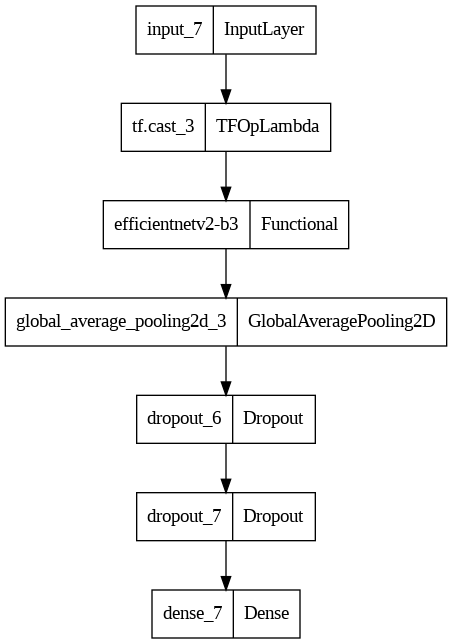

In [15]:
input_layer = Input([456 , 456 , 3])
x = tf.cast(input_layer , dtype = tf.float32)
x = efficientnetpre(x)

efficientnet_model = EfficientNetV2B3(weights = 'imagenet' , include_top = False)(x)

output_layer = GlobalAveragePooling2D()(efficientnet_model)
output_layer = Dropout(0.4)(output_layer)
ouput_layer = Dense(1024 , activation = 'relu')(output_layer)
output_layer = Dropout(0.2)(output_layer)
output_layer = Dense(num_classes , activation = 'softmax')(output_layer)

efficientnet_custom_model = Model(inputs = input_layer, outputs = output_layer)

efficientnet_custom_model.compile(optimizer = Adam(0.0001) , loss = 'categorical_crossentropy' , metrics = [F1Score(average = 'micro')])
keras.utils.plot_model(efficientnet_custom_model)
